# Import

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import fastai
from fastai.imports import *
from fastai.basics import *
from fastai.metrics import accuracy
from fastai.torch_core import *
from fastai.vision import *
fastai.__version__

'1.0.51'

In [6]:
from fastai_audio import *

# Data

Download https://github.com/soerenab/AudioMNIST/archive/master.zip

Paper https://arxiv.org/abs/1807.03418

In [7]:
FASTAI_DATASET_PATH = Path(Config().data_path())
data_path = FASTAI_DATASET_PATH/"AudioMNIST"/"data"
data_path

WindowsPath('D:/.fastai/data/AudioMNIST/data')

Get metadata

In [8]:
metadata = pd.read_json(data_path/"audioMNIST_meta.txt").T
metadata.head()

,accent,age,gender,native speaker,origin,recordingdate,recordingroom
1,german,30,male,no,"Europe, Germany, Wuerzburg",17-06-22-11-04-28,Kino
2,German,25,male,no,"Europe, Germany, Hamburg",17-06-26-17-57-29,Kino
3,German,31,male,no,"Europe, Germany, Bremen",17-06-30-17-34-51,Kino
4,German,23,male,no,"Europe, Germany, Helmstedt",17-06-30-18-09-14,Kino
5,German,25,male,no,"Europe, Germany, Hameln",17-07-06-10-53-10,Kino


Merge metadata with relative file path

In [9]:
wave_file_paths = list(data_path.glob("**/*.wav"))
df = pd.DataFrame([{"relative_path": os.path.join(wave_file_path.parts[-2], 
                                             wave_file_path.parts[-1]), 
                    "speaker_id": int(wave_file_path.parts[-2]),
                    "digits": int(re.search("^(.+)_.+_.+", wave_file_path.stem)[1])}
              for wave_file_path in wave_file_paths])

df = df.merge(metadata, left_on="speaker_id", right_index=True)

In [10]:
df = df.sample(frac=1).reset_index(drop=True)
df.tail()

,digits,relative_path,speaker_id,accent,age,gender,native speaker,origin,recordingdate,recordingroom
29995,0,20\0_20_4.wav,20,German,25,male,no,"Europe, Germany, Berlin",17-08-14-17-27-02,Ruheraum
29996,3,23\3_23_17.wav,23,German,28,male,no,"Europe, Germany, Alsbach-Haehnlein",17-08-16-14-17-44,VR-Room
29997,0,29\0_29_48.wav,29,German,23,male,no,"Europe, Germany, Freiburg",17-09-14-20-54-30,vr-room
29998,2,10\2_10_37.wav,10,German,36,male,no,"Europe, Germany, Lemgo",17-07-12-17-31-43,Kino
29999,9,37\9_37_7.wav,37,Italian,27,male,no,"Europe, Italy, Casarsa",17-09-01-09-46-46,vr-room


In [11]:
df.groupby("gender")["gender"].count()/df.shape[0]

gender
female    0.2
male      0.8
Name: gender, dtype: float64

In [12]:
df.groupby("digits")["digits"].count()/df.shape[0]

digits
0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: digits, dtype: float64

# Dataloader

In [13]:
from fastai_audio import *

n_fft = 512 # output of fft will have shape [513 x n_frames]
n_hop = 60  # width of Spectogram = max_seconds * sample rate / n_hop
n_mels = 64 # Height of spectogram
sample_rate = 48000
max_seconds = 0.5
f_min=0
f_max=8000
noise_scl=0.002


train_tfms = get_data_augmentation_transforms(sample_rate=sample_rate, max_seconds=max_seconds, 
                                              noise_scl=noise_scl)
valid_tfms = get_data_augmentation_transforms(sample_rate=sample_rate, max_seconds=max_seconds)

dl_tfms = get_frequency_batch_transforms(n_fft=n_fft, n_hop=n_hop,
                                            n_mels=n_mels, 
                                            f_min=f_min, f_max=f_max,
                                            sample_rate=sample_rate)

In [14]:
%%prun
from fastai_audio import *
batch_size = 64

audios = (AudioItemList.from_df(df=df, path=data_path, cols="relative_path", using_librosa=True, downsampling=None)
          .split_by_rand_pct(0.1)
          .label_from_df(cols="digits")
          .transform(tfms=(train_tfms, valid_tfms))
          .databunch(bs=batch_size, tfms=dl_tfms, num_workers=3)
            ).normalize()

In [12]:
audios.c, len(audios.train_ds), len(audios.valid_ds)

(10, 27000, 3000)

# Look at data from dataloader

In [13]:
xs, ys = audios.one_batch()
print(xs.shape, ys.shape)
del xs, ys

torch.Size([64, 1, 64, 401]) torch.Size([64])


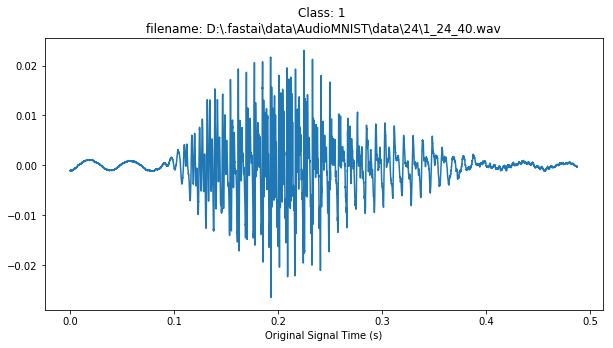

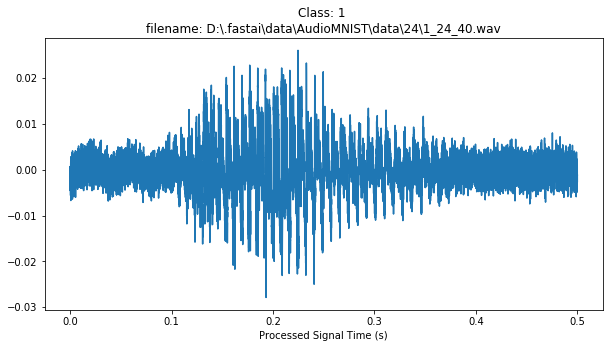

'Original signal'

'Processed signal'

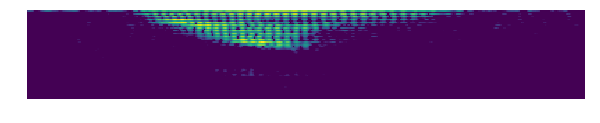

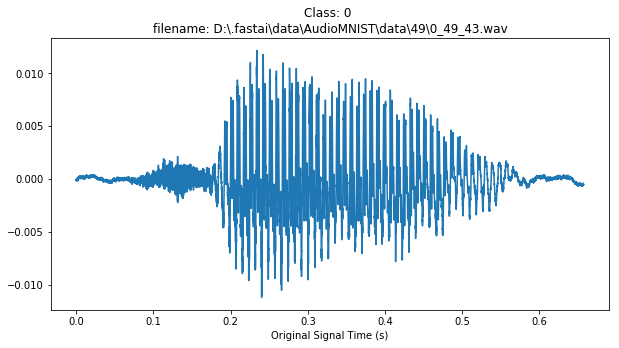

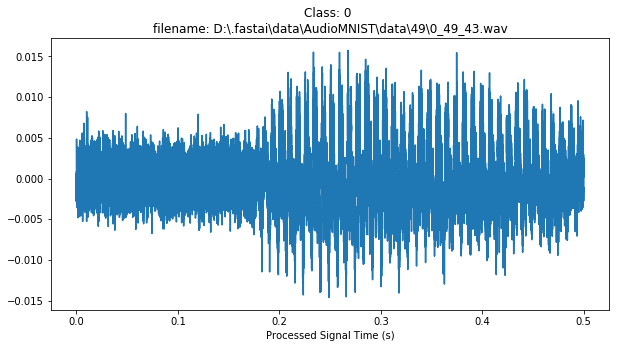

'Original signal'

'Processed signal'

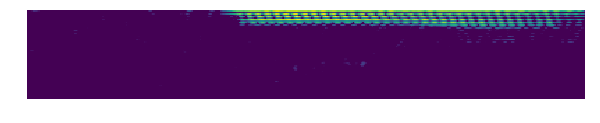

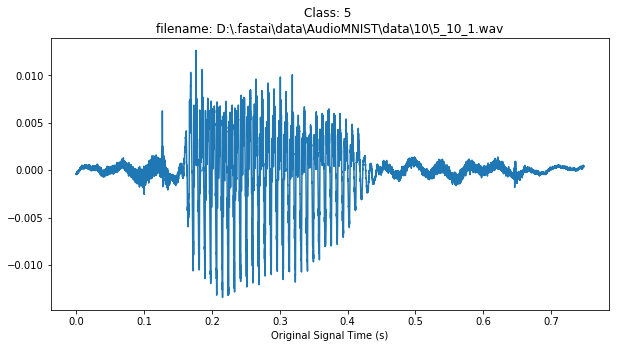

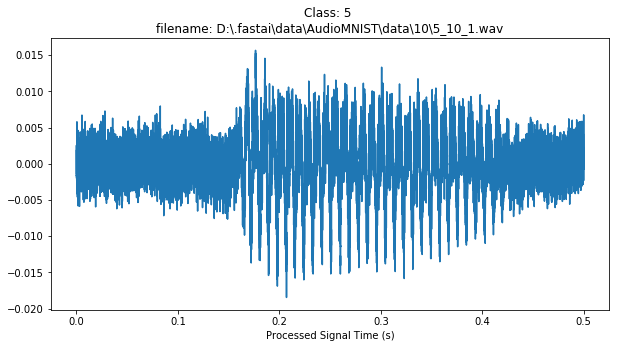

'Original signal'

'Processed signal'

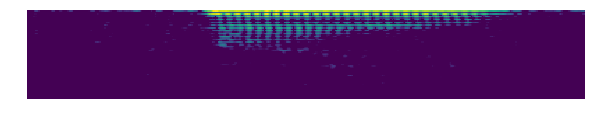

In [14]:
audios.show_batch(3, ds_type=DatasetType.Train, figsize=(10, 5))

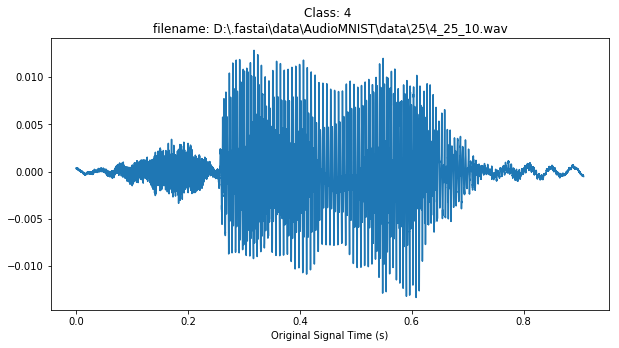

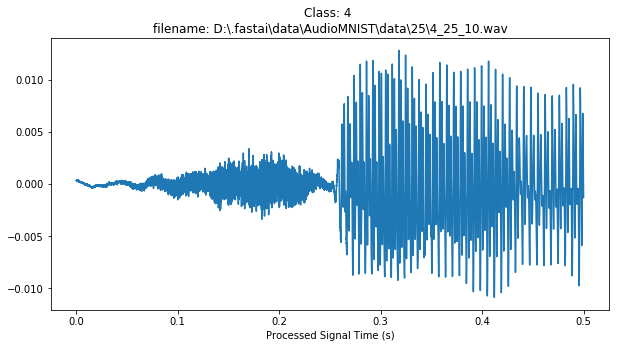

'Original signal'

'Processed signal'

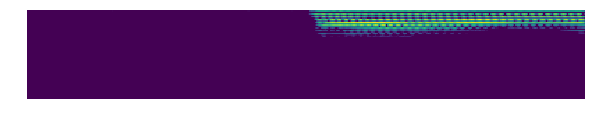

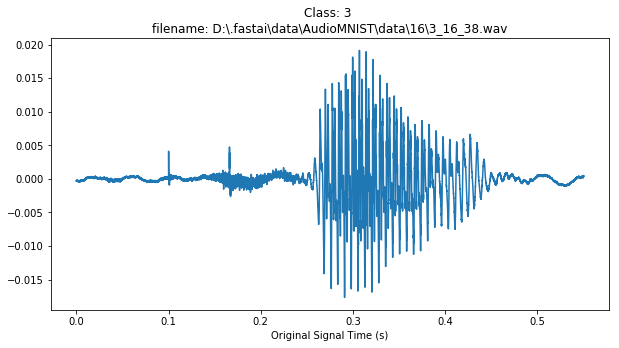

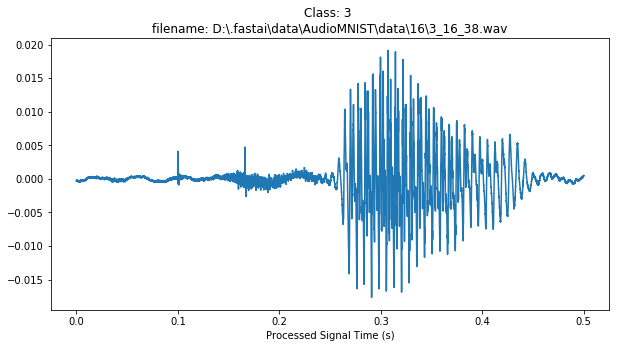

'Original signal'

'Processed signal'

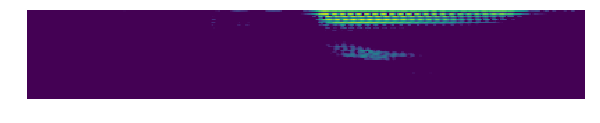

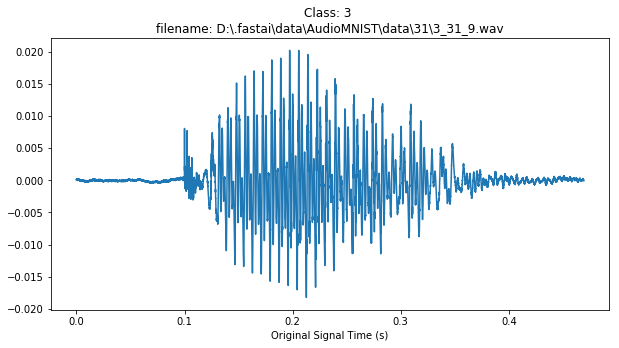

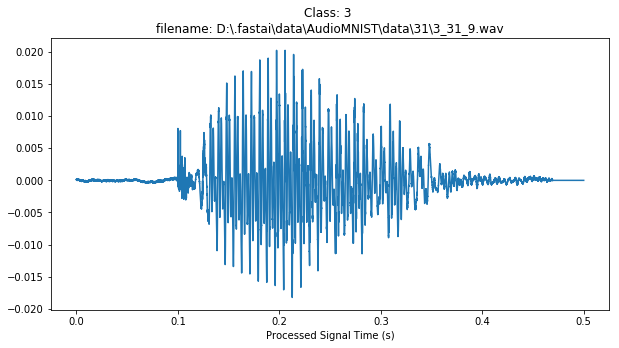

'Original signal'

'Processed signal'

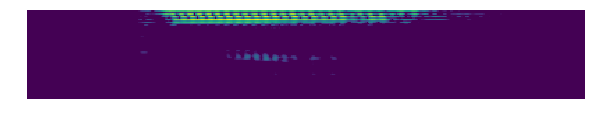

In [15]:
audios.show_batch(3, ds_type=DatasetType.Valid, figsize=(10, 5))

# Model with pretraining

In [16]:
learn = create_cnn(audios, models.resnet18, metrics=accuracy, pretrained=True)

In [17]:
#learn.summary()

# Training

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


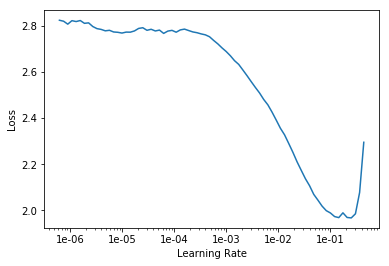

In [19]:
learn.recorder.plot()

In [20]:
#%%prun
learn.fit_one_cycle(2, max_lr=3e-3)
learn.save("stage1")

epoch,train_loss,valid_loss,accuracy,time
0,0.144793,0.143850,0.952667,01:15
1,0.061270,0.099003,0.968333,01:20


In [21]:
learn = learn.load("stage1")
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


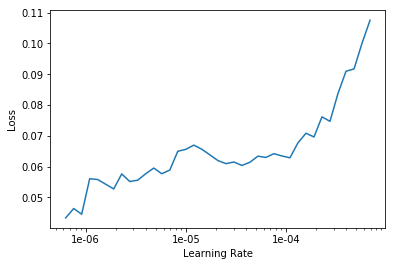

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 8e-5))
learn.save("pretrained")

epoch,train_loss,valid_loss,accuracy,time
0,0.046287,0.075873,0.975000,01:18
1,0.038668,0.070366,0.976333,01:16


# Model interpretration

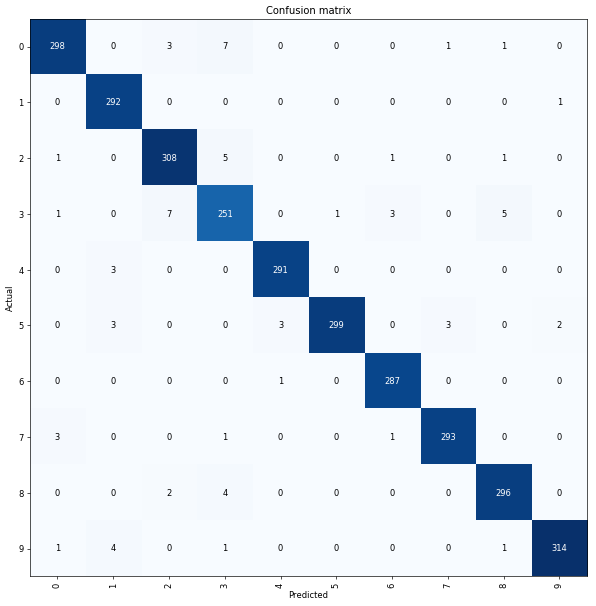

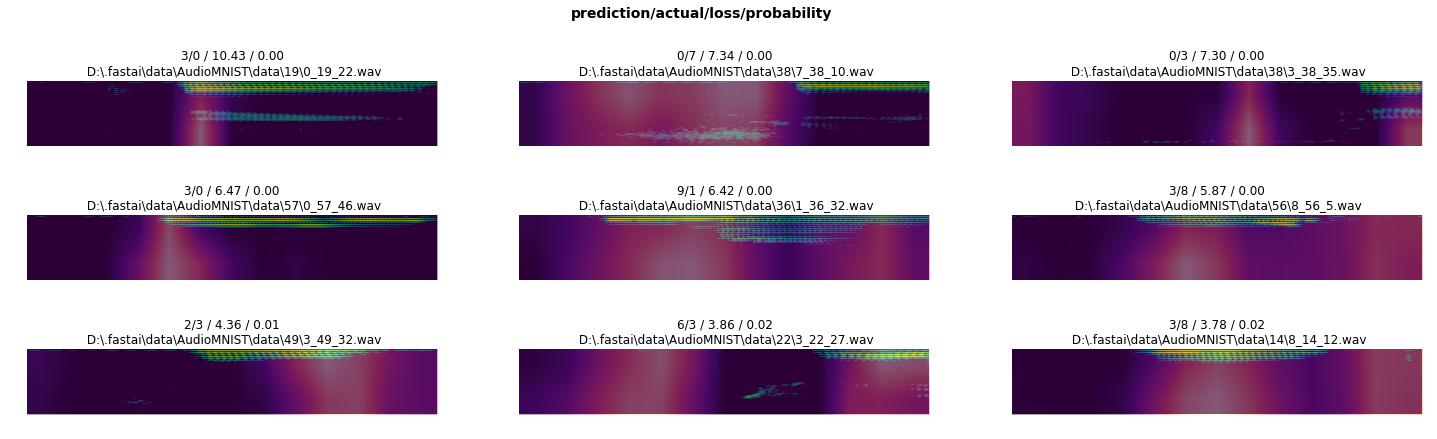

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)
interp.plot_audio_top_losses(9)

# Model without pretraining

In [25]:
learn = create_cnn(audios, models.resnet18, metrics=accuracy, pretrained=False)

# Training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


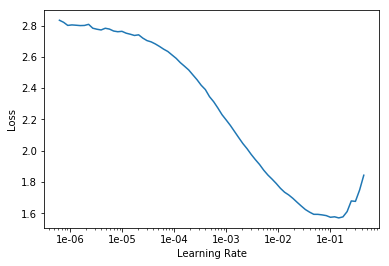

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(2, max_lr=3e-3)
learn.save("stage1")

epoch,train_loss,valid_loss,accuracy,time
0,0.122896,0.188390,0.934667,01:25
1,0.035289,0.051604,0.984667,01:15


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


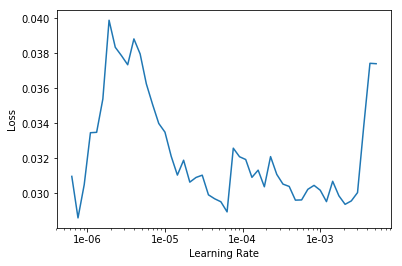

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn = learn.load("stage1")
learn.fit_one_cycle(2, max_lr=1e-6)
learn.save("not_pretrained")

epoch,train_loss,valid_loss,accuracy,time
0,0.026535,0.052797,0.983333,01:16
1,0.026557,0.054310,0.983000,01:11


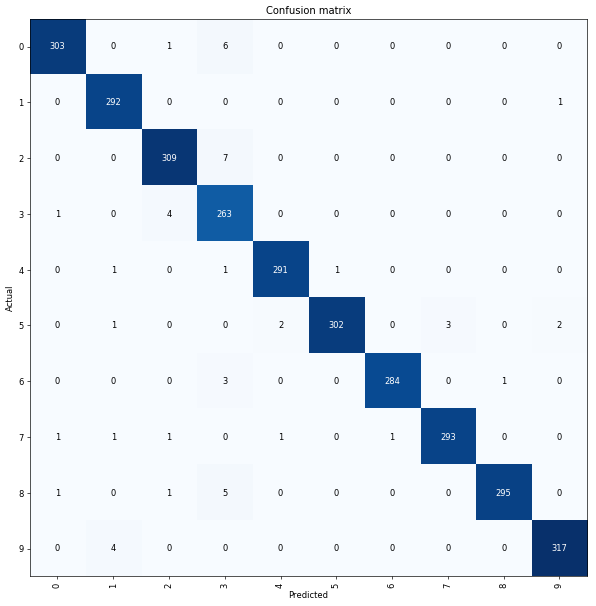

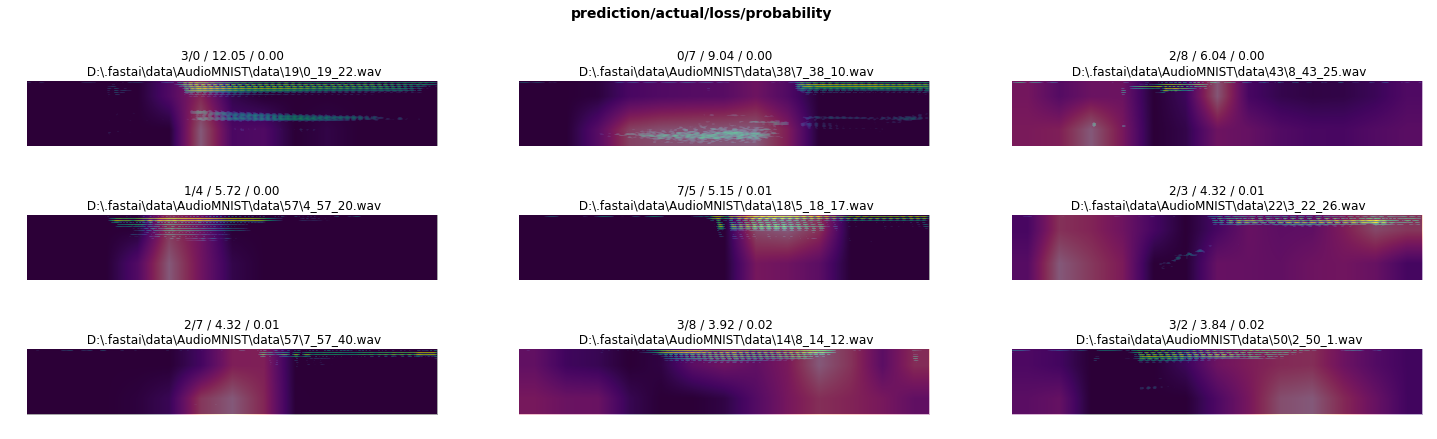

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)
interp.plot_audio_top_losses(9)

# Better approach without pretraining

This makes sense as Imagenet features may not be relevant for spectograms.

The benchmark is 95.8% from the paper https://arxiv.org/pdf/1807.03418.pdf

This implementation without pretraining reaches >98% 

In [31]:
learn = learn.load("not_pretrained")

Most confused as actual, predicted, number of occurences
[(2, 3, 7), (0, 3, 6), (8, 3, 5), (3, 2, 4), (9, 1, 4), (5, 7, 3), (6, 3, 3), (5, 4, 2), (5, 9, 2)]


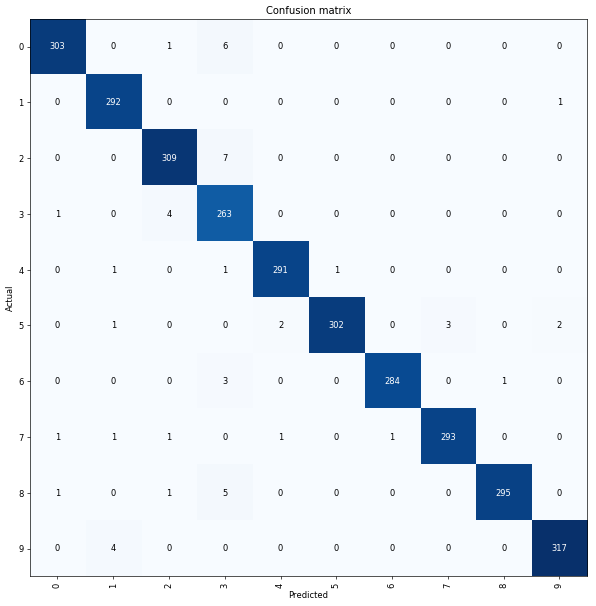

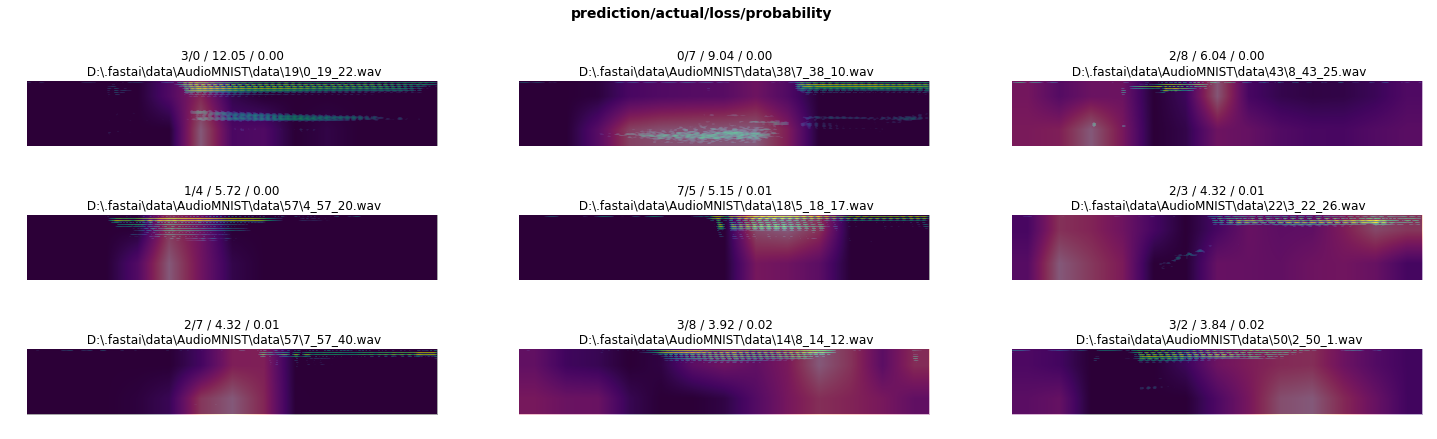

In [32]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)

print("Most confused as actual, predicted, number of occurences")
print(interp.most_confused(min_val=2)[:10])

interp.plot_audio_top_losses(9)